In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as mc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [72]:
# Constants
iob = {
    'Novolog': datetime.timedelta(hours=4),
    'Lantus': datetime.timedelta(hours=30)
}

cob = datetime.timedelta(hours=2)

In [86]:
# Load raw data
import csv
import datetime
import intervaltree as it

refdate = datetime.datetime(1970,1,1)
def t2i(t):
    return (t-refdate).total_seconds()

raw = {
    'timeline': it.IntervalTree(),
    'bg': []
}

with open('Glucose.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if len(row) < 9:
            continue
        if row[0] == 'Date':
            continue
        
        t = datetime.datetime.strptime(row[0] + " " + row[1], '%Y/%m/%d %H:%M')
        bg = float(row[2])
        carbs = float(row[5])
        ins = float(row[7])
        itype = row[8]
        if bg == 0 and carbs == 0 and ins > 0:
            tt = t + iob[itype]
            raw['timeline'][t2i(t):t2i(tt)] = (itype, ins)
        if carbs != 0:
            tt = t + cob
            raw['timeline'][t2i(t):t2i(tt)] = ('carbs', carbs)
        if bg != 0:
            raw['bg'].append((t, bg))

print 'bg readings:', len(raw['bg'])

bg readings: 84


In [109]:
# Process data

BG0 = []
BG1 = []
DBG = []
BOL = []
CAR = []

for i in range(len(raw['bg'])-1):
    (t1, bg1) = raw['bg'][i]
    (t0, bg0) = raw['bg'][i+1]
    
    params = {}
    params['Novolog'] = 0
    params['Lantus'] = 0
    params['carbs'] = 0
    for event in raw['timeline'][t2i(t0):t2i(t1)]:
        (typ, val) = event.data
        ## TODO: weight partial events
        params[typ] += val
    
#     data.append((bg0, bg1, params['Novolog'], params['Lantus'], params['carbs']))
    BG0.append(bg0)
    BG1.append(bg1)
    DBG.append(bg1-bg0)
    BOL.append(params['Novolog'])
    CAR.append(params['carbs'])

print "observations:", len(DBG)
print "observation_0:", BG0[0], BG1[0], DBG[0], BOL[0], CAR[0]

observations: 83
observation_0: 89.0 95.0 6.0 9.0 116.0


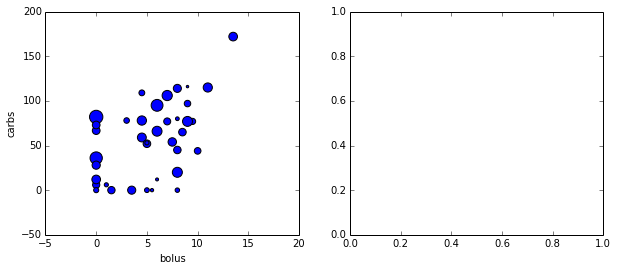

In [110]:
fig, axes = subplots(1, 2, figsize=(10,4))

axes[0].set_ylabel('carbs')
axes[0].set_xlabel('bolus')
axes[0].scatter(BOL, CAR, s=DBG)

In [118]:
model = mc.Model()

with model:
    
    k_car = mc.Normal('k_car', mu=3.5, sd=1) ## TODO: better distribution choice
    k_bol = mc.Normal('k_bol', mu=-50, sd=15) ## TODO: better distribution choice
    sigma_bg1 = mc.HalfNormal('sigma_bg', sd=1)
    
    expected_bg1 = BG0 + k_car*CAR + k_bol*BOL
    
    actual_bg1 = mc.Normal('actual_bg1', mu=expected_bg1, sd=sigma_bg1, observed=BG1)

 [-----------------100%-----------------] 10000 of 10000 complete in 8.5 sec
k_car:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.486            0.073            0.002            [0.346, 0.634]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.341          0.437          0.486          0.535          0.630


k_bol:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.780           0.716            0.015            [-6.213, -3.412]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.172         -5.267         -4.778         -4.302         -3.362


sigma_bg_log:

  Mean     

array([[<matplotlib.axes.AxesSubplot object at 0x117e4b390>,
        <matplotlib.axes.AxesSubplot object at 0x11b228310>]], dtype=object)

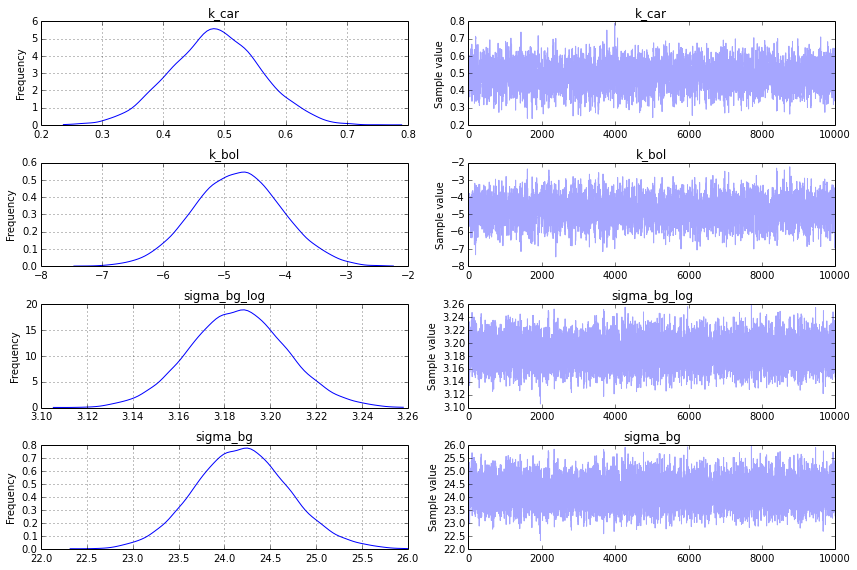

In [119]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS(scaling=start)
    trace = mc.sample(10000, step, start=start)

print mc.summary(trace)
mc.traceplot(trace)